In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from matplotlib.colors import LinearSegmentedColormap as LSC
from matplotlib.colors import LogNorm
import swiftascmaps
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns

In [2]:
f = pd.read_csv("/Users/user/Desktop/Results/Thesis/Chapter 3/Data/output2.dat", 
                sep = "\t", header = 0)

print("Number of columns: ", len(f.columns.tolist()), "\n", "Number of stars: ", 
      len(f.index), "\n\n", f.columns.tolist(), sep = "")

Number of columns: 18
Number of stars: 2012568

['Unnamed: 0', 'Age', 'Array Index', 'B_init (G)', 'Distance (kpc)', 'Galactic Latitude (degrees)', 'Galactic Longitude (degrees)', 'Initial Period (s)', 'Misalignment angle', 'Pdot (s s^-1)', 'Period (ms)', 'Type', 'Vx', 'Vy', 'Vz', 'X (kpc)', 'Y (kpc)', 'Z (kpc)']


<h1> Survey using $\texttt{PsrPopPy}$ </h1>


In [3]:
from MainFile import Find_decent_Vrel as fdV

bl = fdV([np.array(f["X (kpc)"]), np.array(f["Y (kpc)"]), np.array(f["Z (kpc)"])],
         [np.array(f["Vx"]), np.array(f["Vy"]), np.array(f["Vz"])],
         np.array(f["Distance (kpc)"]))

print("\nInitial Number of stars:", len(f.index))
ff = f[bl.check_Vrel(-1000, 1000)]
print("Number of stars after reduction:", len(ff.index))

print(" Max and min logB:", np.log10(np.max(ff["B_init (G)"])), np.log10(np.min(ff["B_init (G)"])), "\n",
     "Max and min Period:", np.max(ff["Period (ms)"])/1000, np.min(ff["Period (ms)"])/1000, "\n",
     "Max and min alpha:", np.max(ff["Misalignment angle"]), np.min(ff["Misalignment angle"]))


Initial Number of stars: 2012568


/var/folders/zn/fx9ngdfs335czg37p256r4_00000gp/T/ipykernel_25660/4160193979.py:3: SyntaxWarning: 
Order of parameters: [X, Y, Z]; [Vx, Vy, Vz]; distance
  bl = fdV([np.array(f["X (kpc)"]), np.array(f["Y (kpc)"]), np.array(f["Z (kpc)"])],


Number of stars after reduction: 2000916
 Max and min logB: 14.485565524376133 10.170931013924543 
 Max and min Period: 9.999366678307943 0.010100008421282381 
 Max and min alpha: 89.99999388166276 0.0219549931538406


In [4]:
B = ff["B_init (G)"]
P = ff["Period (ms)"] /1000
alpha = ff["Misalignment angle"] * np.pi/180
pos = [np.array(ff["X (kpc)"]), np.array(ff["Y (kpc)"]), np.array(ff["Z (kpc)"])]
vel = [np.array(ff["Vx"]), np.array(ff["Vy"]), np.array(ff["Vz"])]
distance = ff["Distance (kpc)"]
distance_from_GC = np.sqrt( (pos[0]*pos[0]) + (pos[1]*pos[1]) + (pos[2]*pos[2]) )

<h2>NFW profile</h2>

In [5]:
c = 299_792_458 # m/s
hbar = 6.582119 * 1e-25 # GeV . s
sec = (1/hbar) # GeV^-1
m = (1/c) * sec # GeV^-1
kg = (1/1.7827) * 1e27 # GeV
GEV = 1
cm = 0.01 * m

rho_init = 0.45 * GEV / (cm**3) # GeV^4

rs = 8.1 # kpc
r_rs = (8/8.1)

rho_s = 0.51 * (r_rs) * ((1+r_rs)**2) # GeV^4
print(rho_s, "in GeV/cm^3")
rho_NFW = lambda r: rho_s / ( (r/rs) * (( 1 + (r/rs) )**2) ) * GEV / (cm**3)

1.9900173302398574 in GeV/cm^3


In [6]:
# Gaussian function to fit

from scipy.optimize import curve_fit as cf

def gaussian(x, A, loc, scale):
    return norm.pdf(x, loc, scale) * A

def gauss_fit_plot(X,Y, popt):
    x = np.linspace(X[0], X[-1], 100)
    with plt.style.context("seaborn-v0_8-whitegrid"):
        plt.rcParams["font.family"] = "serif"
        plt.plot(X, 1e6 * Y)
        plt.fill_between(X, 1e6 * Y, alpha = 0.3, step = "mid", color = "C0")
        plt.scatter(X, 1e6 * Y, marker = ".", color = "black")
        
        plt.plot(x, 1e6 * gaussian(x, *popt), label = "Gaussian fit", color = "C3")
        plt.xlabel("Frequency (MHz)")
        plt.ylabel(r"Brightness Temperature ($\mu$K)")
        plt.legend()

In [7]:
bins = 10 ** np.linspace(np.log10(np.min(ff["B_init (G)"])), np.log10(np.max(ff["B_init (G)"])), 25)

def Bbins(L, bandwidth):
    binned_power = []
    count = []
    
    binned_flux = []
    binned_temperature = []
    dataframe = pd.DataFrame({"B": ff["B_init (G)"], 
                             "L": L,
                             "dist": ff["Distance (kpc)"]})
    
    for i in range(bins.size - 1):
        ffff = dataframe[(bins[i] <= dataframe["B"]) & (dataframe["B"] <= bins[i+1])]
        count.append(len(ffff["L"].index))
        binned_power.append(np.sum(np.array(ffff["L"])))
        
        flux = np.array(ffff["L"]) / (4 * np.pi * np.array(ffff["dist"])**2 * bandwidth) 
        flux = (flux / (3.086e19 * 3.086e19)) * 1e26
        binned_flux.append(np.sum(flux))

    bin_center = 10 ** (np.log10(bins[:-1]) + (np.log10(bins[1:])-np.log10(bins[:-1]))/2)
    return bin_center, binned_flux, count

In [8]:
def Bplots(bin_center, binned_flux, count):
    fig = plt.figure(figsize = (12,5))
    
    with plt.style.context("bmh"):
        plt.rcParams["font.family"] = "serif"
        plt.rcParams['axes.axisbelow'] = True
        
        bar1 = plt.bar(bin_center, np.array(binned_flux), width = np.diff(bins), 
                       log = "True", ec = "black")
        
        for rect, items in zip(bar1, count):
            height = rect.get_height()
            # print(np.log10(rect.get_x() + rect.get_width() / 2.0), f'{height:.0f}')
            # print(type(height)
            if(height != 0 and items < 10000):
                plt.text(10**np.log10(rect.get_x() + rect.get_width() / 2.0), 10**np.log10(height), items, 
                         ha='center', va='top', rotation = 90, color = "white", size = 12)
    
            elif(height != 0 and items > 10000):
                plt.text(10**np.log10(rect.get_x() + rect.get_width() / 2.0), 10**np.log10(height),
                         str(int(items/1000)) + " k ", 
                         ha='center', va='top', rotation = 90, color = "yellow", size = 12)
    
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel(r"Magnetic Field ($G$)", fontsize = 16)
    plt.ylabel(r"Total Power of the population $(W)$", fontsize = 16)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    # plt.savefig("/Users/user/Desktop/Results/Report 5.0/L_vs_B.png", bbox_inches = "tight", dpi = 300)

<h2> $m_a = 0.1  \ \mu eV$</h2>

/var/folders/zn/fx9ngdfs335czg37p256r4_00000gp/T/ipykernel_25660/4076299591.py:3: SyntaxWarning: Order of parameters: B (in G), P (in seconds), alpha (in radiens), co-ordinates(x, y, z) (in kpc), velocity(vx, vy, vz) (in km/s), distance (in kpc), axion mass (in micro eV) and time (in Million years). Permissible axion mass values - 0.1, 1, 10, 16.543 (4 GHz), 24.814 (6 GHz), 33.085 (8 GHz), 100.
  stars01 = Surface_Element(B, P, alpha, pos, vel, distance, 0.1)


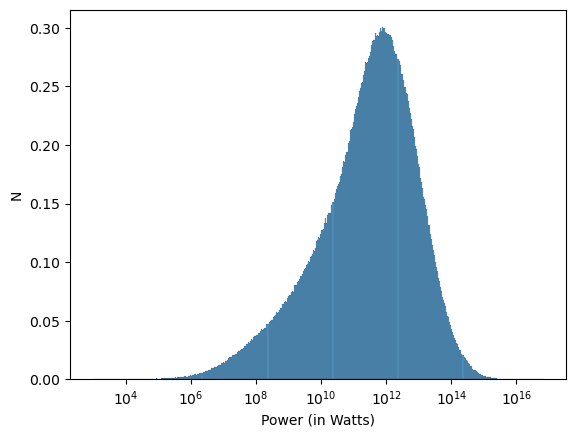

In [9]:
from MainFile import Surface_Element

stars01 = Surface_Element(B, P, alpha, pos, vel, distance, 0.1)

L_01 = stars01.interpolation() * 1.602176634e-19

#introducing DM NFW profile
L_01 = (L_01/rho_init) * rho_NFW(distance_from_GC)

sns.histplot(L_01, stat = "density", log_scale = 10)
plt.xlabel("Power (in Watts)")
plt.ylabel("N")
plt.show()

In [10]:
fobs01 = stars01.fobs()

delf_c_01, I_01, num01 = stars01.allsky_intensity(fobs01, L_01, bandwidth = 1e4)

kb = 1.380649e-23 * 1e26 # Jy m^2 K^-1
ma_01 = 1000 * 0.1 * 1e-6 * stars01.freq_factor # MHz
axion_wv_01 = (stars01.c*1000) / (ma_01 * 1e6) # m
print(f"Wavelength corresponding to ma = 0.1  mueV: %.5f" % axion_wv_01, "m", sep = " ")

print(f"Frequency =  %.5f" % ma_01, "MHz")
# System Temperature
T_01 = I_01 * (axion_wv_01**2) / (2 * kb)

Wavelength corresponding to ma = 0.1  mueV: 12.41529 m
Frequency =  24.14704 MHz


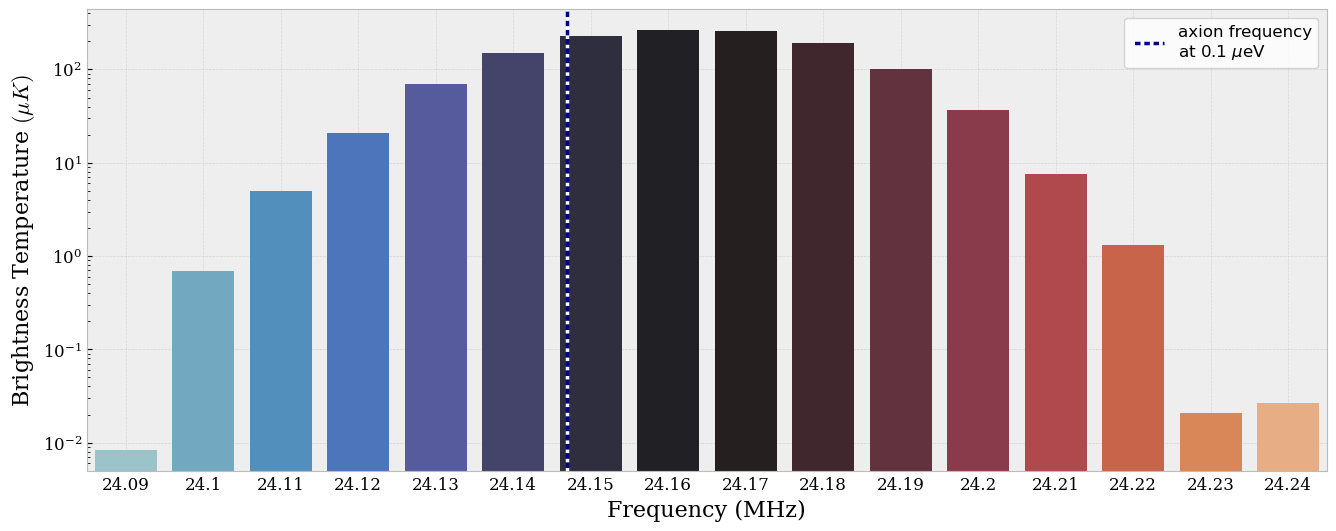

In [11]:
import seaborn as sns
from matplotlib import style

plt.figure(figsize = (16,6))

with plt.style.context('bmh'):
    plt.rcParams["font.family"] = "serif"
    plt.rcParams['axes.axisbelow'] = True
    sns.barplot(x = np.round(1000*delf_c_01, decimals = 2), y = T_01 * 1e6, palette = "icefire")
    plt.axvline(x = (ma_01 - 1000 * delf_c_01[0]) / (1000 * (delf_c_01[1] - delf_c_01[0])), 
                color = "white", label = r"axion frequency" + "\n" + r"at 0.1 $\mu$eV", alpha = 1,
                linestyle = ":", lw = 2.5, gapcolor = "darkblue")

    plt.yscale("log")
    plt.ylabel(r"Brightness Temperature $(\mu K)$", fontsize = 13+3)
    plt.xlabel("Frequency (MHz)", fontsize = 13+3)
    plt.xticks(fontsize = 11+1)
    plt.yticks(fontsize = 11+1)
plt.legend(labelcolor = "black", facecolor = "white", fontsize = "large")
plt.grid(alpha = 0.4)
plt.show()

[1.35524481e-05 2.41625455e+01 1.95956980e-02] in units of K, MHz, MHz.


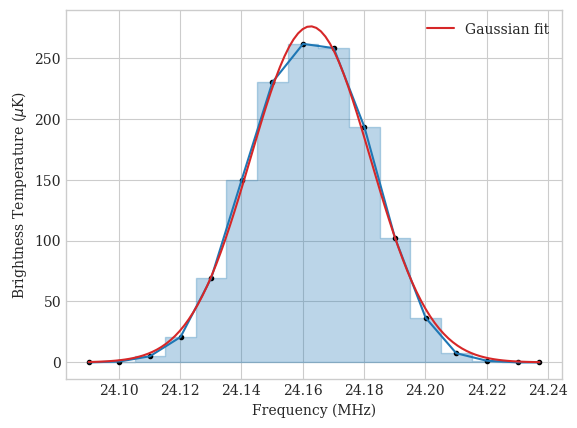

In [12]:
popt_01, pcov_01 = cf(gaussian, 1000 * delf_c_01, T_01, p0 = [1e-6, ma_01, 0.1])

print(popt_01, "in units of K, MHz, MHz.", sep = " ")

gauss_fit_plot(1000 * delf_c_01, T_01, popt_01)
plt.show()

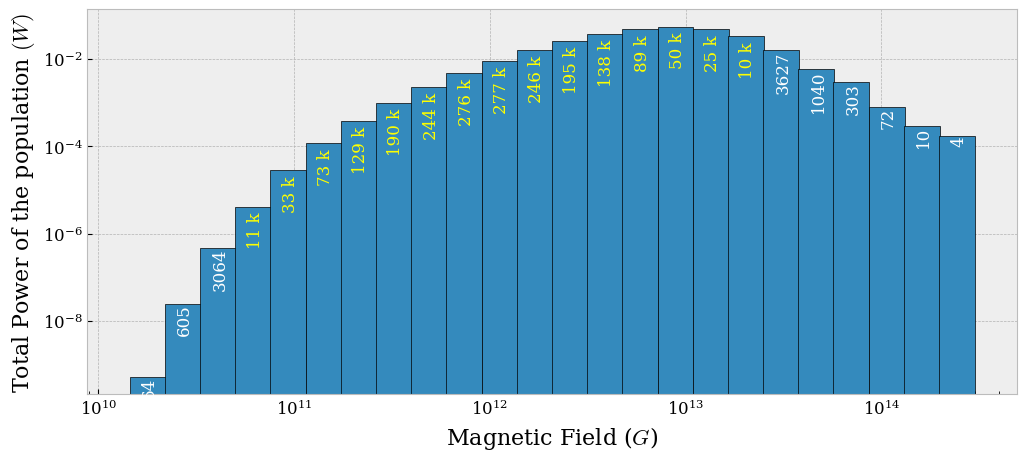

In [13]:
bins_01, bflux_01, count_01 = Bbins(L_01, 1e4)

Bplots(bins_01, bflux_01, count_01)
plt.show()

In [14]:
print("Number of Neutron stars contributing = ", (L_01[L_01 > 1e4]).size)

Number of Neutron stars contributing =  2000863


<h2>$m_a = 1 \ \mu eV$</h2>

/var/folders/zn/fx9ngdfs335czg37p256r4_00000gp/T/ipykernel_25660/841686507.py:3: SyntaxWarning: Order of parameters: B (in G), P (in seconds), alpha (in radiens), co-ordinates(x, y, z) (in kpc), velocity(vx, vy, vz) (in km/s), distance (in kpc), axion mass (in micro eV) and time (in Million years). Permissible axion mass values - 0.1, 1, 10, 16.543 (4 GHz), 24.814 (6 GHz), 33.085 (8 GHz), 100.
  stars1 = Surface_Element(B, P, alpha, pos, vel, distance, 1)


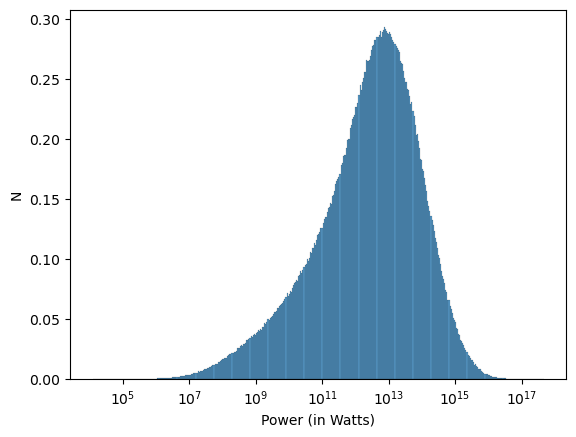

In [15]:
from MainFile import Surface_Element

stars1 = Surface_Element(B, P, alpha, pos, vel, distance, 1)

L_1 = stars1.interpolation() * 1.602176634e-19

#introducing DM NFW profile
L_1 = (L_1/rho_init) * rho_NFW(distance_from_GC)

sns.histplot(L_1, stat = "density", log_scale = 10)
plt.xlabel("Power (in Watts)")
plt.ylabel("N")
plt.show()

In [16]:
fobs1 = stars1.fobs()

delf_c_1, I_1, num1 = stars1.allsky_intensity(fobs1, L_1, bandwidth = 1e5)

kb = 1.380649e-23 * 1e26 # Jy m^2 K^-1
ma_1 = 1000 * 1 * 1e-6 * stars1.freq_factor # MHz
axion_wv_1 = (stars1.c*1000) / (ma_1 * 1e6) # m
print(f"Wavelength corresponding to ma = 1  mueV: %.5f" % axion_wv_1, "m", sep = " ")

print(f"Frequency =  %.5f" % ma_1, "MHz")
# System Temperature
T_1 = I_1 * (axion_wv_1**2) / (2 * kb)

Wavelength corresponding to ma = 1  mueV: 1.24153 m
Frequency =  241.47043 MHz


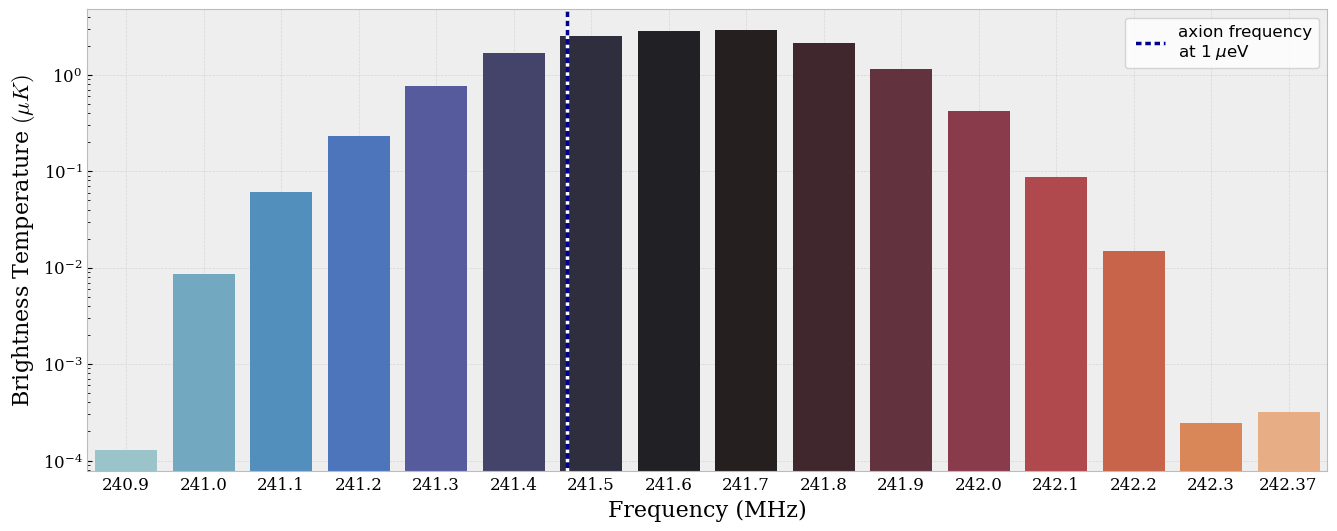

In [17]:
import seaborn as sns
from matplotlib import style

plt.figure(figsize = (16,6))

with plt.style.context('bmh'):
    plt.rcParams["font.family"] = "serif"
    plt.rcParams['axes.axisbelow'] = True
    sns.barplot(x = np.round(1000*delf_c_1, decimals = 2), y = T_1 * 1e6, palette = "icefire")
    plt.axvline(x = (ma_1 - 1000 * delf_c_1[0]) / (1000 * (delf_c_1[1] - delf_c_1[0])), 
                color = "white", label = r"axion frequency" + "\n" + r"at 1 $\mu$eV", alpha = 1,
                linestyle = ":", lw = 2.5, gapcolor = "darkblue")

    plt.yscale("log")
    plt.ylabel(r"Brightness Temperature $(\mu K)$", fontsize = 13+3)
    plt.xlabel("Frequency (MHz)", fontsize = 13+3)
    plt.xticks(fontsize = 11+1)
    plt.yticks(fontsize = 11+1)
plt.legend(labelcolor = "black", facecolor = "white", fontsize = "large")
plt.grid(alpha = 0.4)
# plt.savefig("/Users/user/Desktop/Results/Report 5.0/All_sky_survey_Temp_plot.png", 
#             bbox_inches = "tight", dpi = 300)
plt.show()

[1.49795384e-06 2.41626790e+02 1.97815239e-01] in units of K, MHz, MHz.


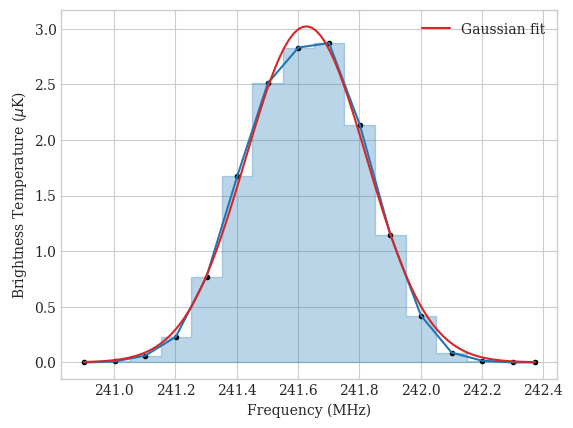

In [18]:
popt_1, pcov_1 = cf(gaussian, 1000 * delf_c_1, T_1, p0 = [1e-6, ma_1, 0.1])

print(popt_1, "in units of K, MHz, MHz.", sep = " ")

gauss_fit_plot(1000 * delf_c_1, T_1, popt_1)
plt.show()

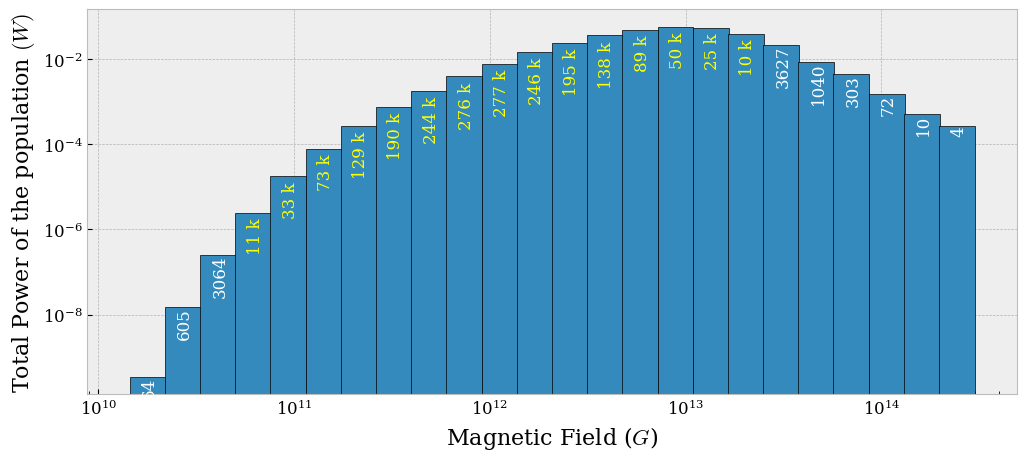

In [19]:
bins_1, bflux_1, count_1 = Bbins(L_1, 1e5)

Bplots(bins_1, bflux_1, count_1)
plt.show()

In [20]:
print("Number of Neutron stars contributing = ", (L_1[L_1 > 1e4]).size)

Number of Neutron stars contributing =  2000916


<h2>$m_a = 10 \ \mu eV$</h2>

/var/folders/zn/fx9ngdfs335czg37p256r4_00000gp/T/ipykernel_25660/3030490747.py:3: SyntaxWarning: Order of parameters: B (in G), P (in seconds), alpha (in radiens), co-ordinates(x, y, z) (in kpc), velocity(vx, vy, vz) (in km/s), distance (in kpc), axion mass (in micro eV) and time (in Million years). Permissible axion mass values - 0.1, 1, 10, 16.543 (4 GHz), 24.814 (6 GHz), 33.085 (8 GHz), 100.
  stars10 = Surface_Element(B, P, alpha, pos, vel, distance, 10)


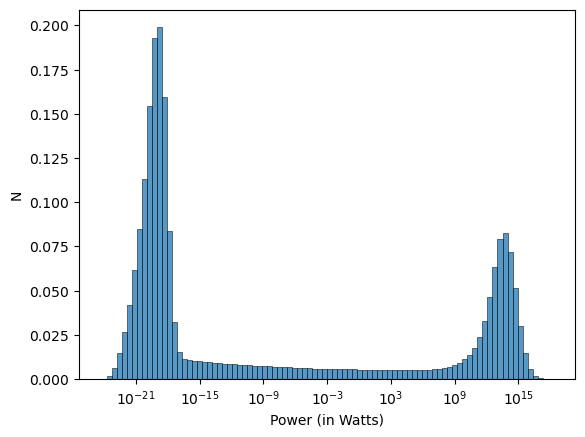

In [21]:
from MainFile import Surface_Element

stars10 = Surface_Element(B, P, alpha, pos, vel, distance, 10)

L_10 = stars10.interpolation() * 1.602176634e-19

#introducing DM NFW profile
L_10 = (L_10/rho_init) * rho_NFW(distance_from_GC)

sns.histplot(L_10, stat = "density", log_scale = 10)
plt.xlabel("Power (in Watts)")
plt.ylabel("N")
plt.show()

In [22]:
fobs10 = stars10.fobs()

delf_c_10, I_10, num10 = stars10.allsky_intensity(fobs10, L_10, bandwidth = 1e6)

kb = 1.380649e-23 * 1e26 # Jy m^2 K^-1
ma_10 = 10 * 1e-6 * stars10.freq_factor # GHz
axion_wv_10 = (stars10.c * 1000) / (ma_10 * 1e9) # m
print(f"Wavelength corresponding to ma = 10  mueV: %.5f" % axion_wv_10, "m", sep = " ")
print(f"Frequency =  %.5f" % ma_10, "GHz")
# System Temperature
T_10 = I_10 * (axion_wv_10**2) / (2 * kb)

Wavelength corresponding to ma = 10  mueV: 0.12415 m
Frequency =  2.41470 GHz


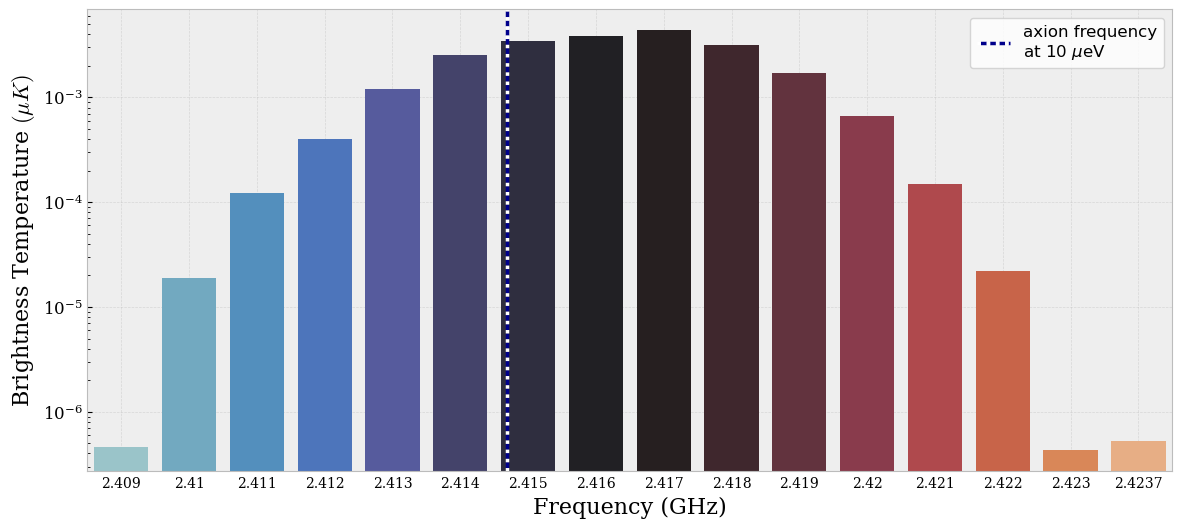

In [23]:
import seaborn as sns
from matplotlib import style

plt.figure(figsize = (14,6))

with plt.style.context('bmh'):
    plt.rcParams["font.family"] = "serif"
    plt.rcParams['axes.axisbelow'] = True
    sns.barplot(x = np.round(delf_c_10, decimals = 4), y = T_10 * 1e6, palette = "icefire")
    plt.axvline(x = (ma_10 - delf_c_10[0]) / ((delf_c_10[2] - delf_c_10[1])), 
                color = "white", label = r"axion frequency" + "\n" + r"at 10 $\mu$eV", alpha = 1,
                linestyle = ":", lw = 2.5, gapcolor = "darkblue")

    plt.yscale("log")
    plt.ylabel(r"Brightness Temperature $(\mu K)$", fontsize = 13+3)
    plt.xlabel("Frequency (GHz)", fontsize = 13+3)
    # plt.xticks(np.linspace(0, 155, 15, dtype = int), fontsize = 10)
    plt.yticks(fontsize = 11+1)
plt.legend(labelcolor = "black", facecolor = "white", fontsize = "large")
plt.grid(alpha = 0.4)
# plt.savefig("/Users/user/Desktop/Results/Report 5.0/All_sky_survey_Temp_plot.png", 
#             bbox_inches = "tight", dpi = 300)
plt.show()

[2.19958741e-08 2.41630692e+03 2.04130025e+00] in units of K, MHz, MHz.


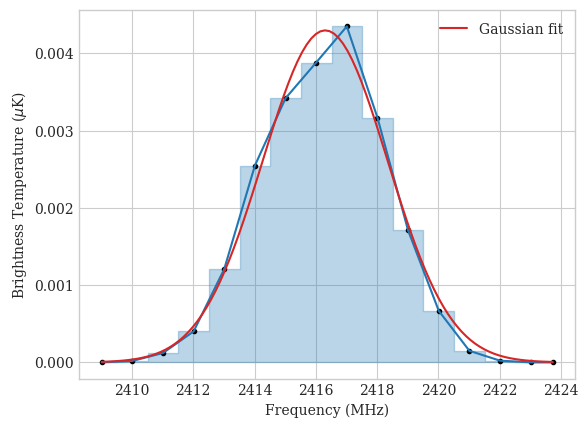

In [24]:
popt_10, pcov_10 = cf(gaussian, 1000 * delf_c_10, T_10, p0 = [1e-9, 1000 * ma_10, 1e1])

print(popt_10, "in units of K, MHz, MHz.", sep = " ")

gauss_fit_plot(1000 * delf_c_10, T_10, popt_10)
plt.show()

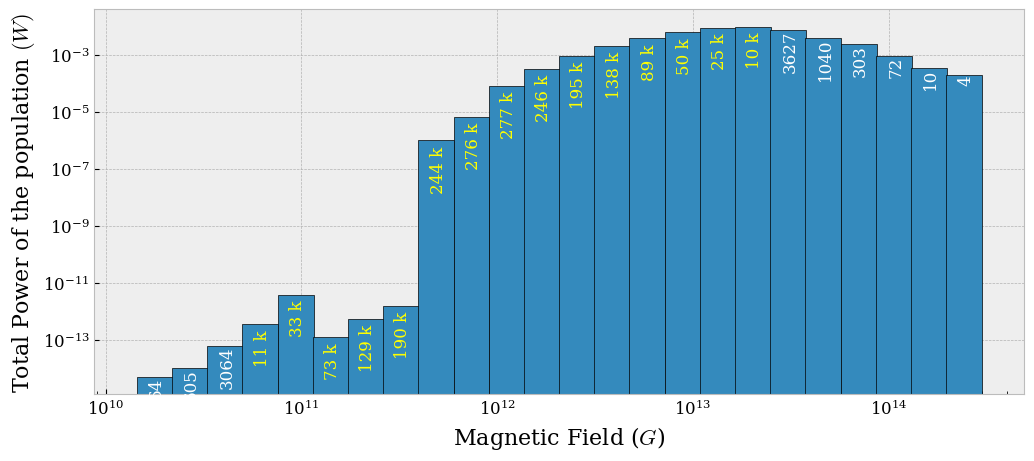

In [25]:
bins_10, bflux_10, count_10 = Bbins(L_10, 1e6)

Bplots(bins_10, bflux_10, count_10)
plt.show()

In [26]:
print("Number of Neutron stars contributing = ", (L_10[L_10 > 1e4]).size)
print(np.max(T_10))

Number of Neutron stars contributing =  587196
4.350312116823604e-09


<h2>$m_a = 100 \  \mu $eV</h2>

/var/folders/zn/fx9ngdfs335czg37p256r4_00000gp/T/ipykernel_25660/1667216093.py:3: SyntaxWarning: Order of parameters: B (in G), P (in seconds), alpha (in radiens), co-ordinates(x, y, z) (in kpc), velocity(vx, vy, vz) (in km/s), distance (in kpc), axion mass (in micro eV) and time (in Million years). Permissible axion mass values - 0.1, 1, 10, 16.543 (4 GHz), 24.814 (6 GHz), 33.085 (8 GHz), 100.
  stars100 = Surface_Element(B, P, alpha, pos, vel, distance, 100)


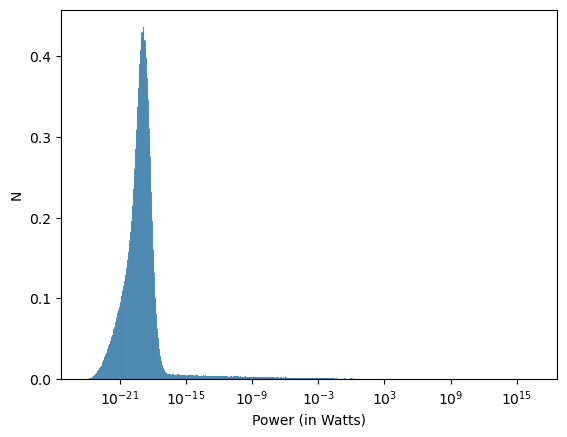

In [27]:
from MainFile import Surface_Element

stars100 = Surface_Element(B, P, alpha, pos, vel, distance, 100)

L_100 = stars100.interpolation() * 1.602176634e-19

#introducing DM NFW profile
L_100 = (L_100/rho_init) * rho_NFW(distance_from_GC)

sns.histplot(L_100, stat = "density", log_scale = 10)
plt.xlabel("Power (in Watts)")
plt.ylabel("N")
plt.show()

In [28]:
fobs100 = stars100.fobs()

delf_c_100, I_100, num100 = stars100.allsky_intensity(fobs100, L_100, bandwidth = 1e7)

kb = 1.380649e-23 * 1e26 # Jy m^2 K^-1
ma_100 = 100 * 1e-6 * stars100.freq_factor # GHz
axion_wv_100 = (stars100.c * 1000) / (ma_100 * 1e9) # m
print(f"Wavelength corresponding to ma = 10  mueV: %.5f" % axion_wv_100, "m", sep = " ")
print(f"Frequency =  %.5f" % ma_100 + " GHz")
# System Temperature
T_100 = I_100 * (axion_wv_100**2) / (2 * kb)

Wavelength corresponding to ma = 10  mueV: 0.01242 m
Frequency =  24.14704 GHz


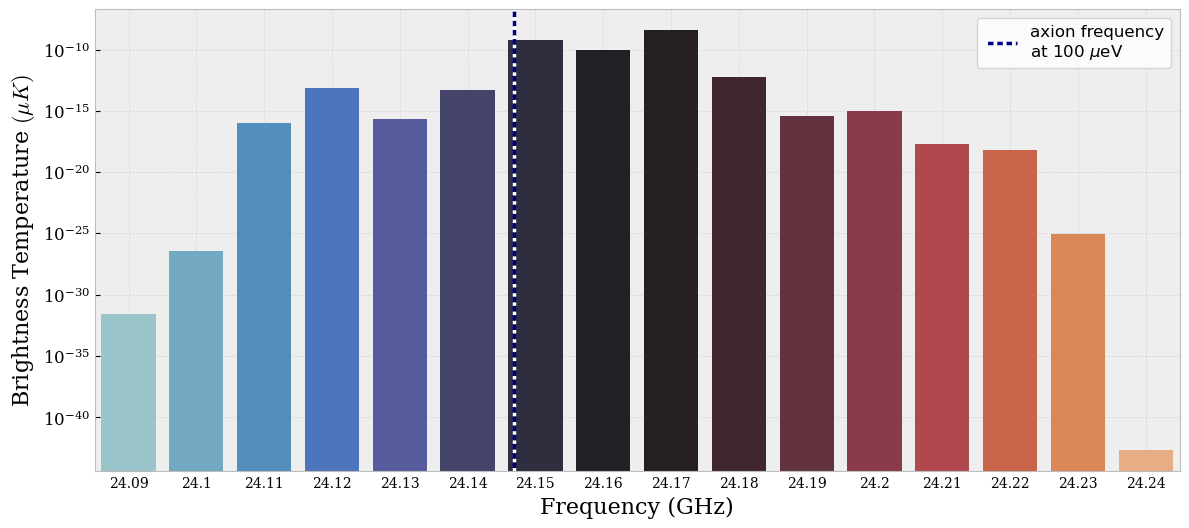

In [29]:
import seaborn as sns
from matplotlib import style

plt.figure(figsize = (14,6))

with plt.style.context('bmh'):
    plt.rcParams["font.family"] = "serif"
    plt.rcParams['axes.axisbelow'] = True
    sns.barplot(x = np.round(delf_c_100, decimals = 2), y = T_100 * 1e6, palette = "icefire")
    plt.axvline(x = (ma_100 - delf_c_100[0]) / ((delf_c_100[2] - delf_c_100[1])), 
                color = "white", label = r"axion frequency" + "\n" + r"at 100 $\mu$eV", alpha = 1,
                linestyle = ":", lw = 2.5, gapcolor = "darkblue")

    plt.yscale("log")
    plt.ylabel(r"Brightness Temperature $(\mu K)$", fontsize = 13+3)
    plt.xlabel("Frequency (GHz)", fontsize = 13+3)
    # plt.xticks(np.linspace(0, 155, 15, dtype = int), fontsize = 10)
    plt.yticks(fontsize = 11+1)
plt.legend(labelcolor = "black", facecolor = "white", fontsize = "large")
plt.grid(alpha = 0.4)
# plt.savefig("/Users/user/Desktop/Results/Report 5.0/All_sky_survey_Temp_plot.png", 
#             bbox_inches = "tight", dpi = 300)
plt.show()

[3.37916751e-14 2.41680515e+04 2.83585361e+00] in units of K, MHz, MHz.


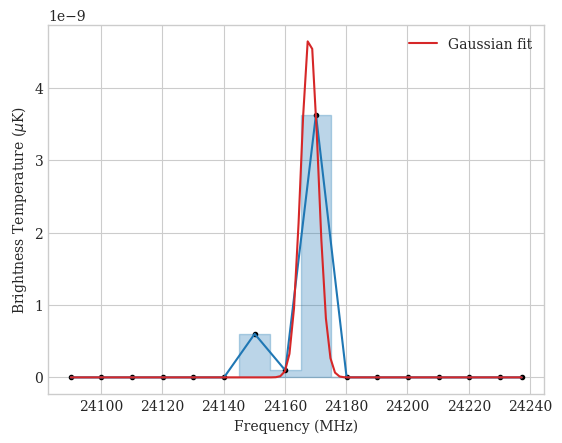

In [30]:
popt_100, pcov_100 = cf(gaussian, 1000 * delf_c_100, T_100, p0 = [1e-9, 1000 * ma_100, 1e2])

print(popt_100, "in units of K, MHz, MHz.", sep = " ")

gauss_fit_plot(1000 * delf_c_100, T_100, popt_100)
plt.show()

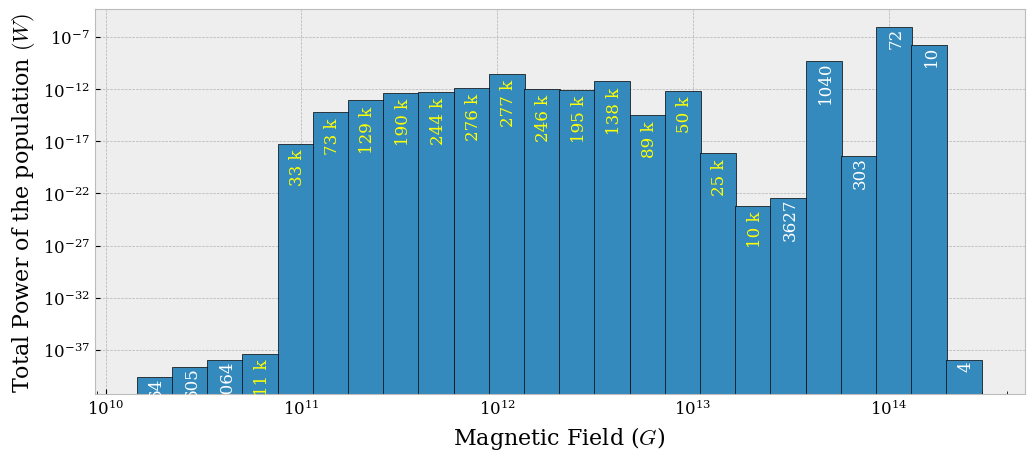

In [31]:
bins_100, bflux_100, count_100 = Bbins(L_100, 1e7)

Bplots(bins_100, bflux_100, count_100)
plt.show()

In [32]:
print("Number of Neutron stars contributing = ", (L_100[L_100 > 1e4]).size)

Number of Neutron stars contributing =  1184


<h2>$f_{m_a} = 4$ GHz</h2>

/var/folders/zn/fx9ngdfs335czg37p256r4_00000gp/T/ipykernel_25660/4137422658.py:4: SyntaxWarning: Order of parameters: B (in G), P (in seconds), alpha (in radiens), co-ordinates(x, y, z) (in kpc), velocity(vx, vy, vz) (in km/s), distance (in kpc), axion mass (in micro eV) and time (in Million years). Permissible axion mass values - 0.1, 1, 10, 16.543 (4 GHz), 24.814 (6 GHz), 33.085 (8 GHz), 100.
  stars4 = Surface_Element(B, P, alpha, pos, vel, distance, 16.543)


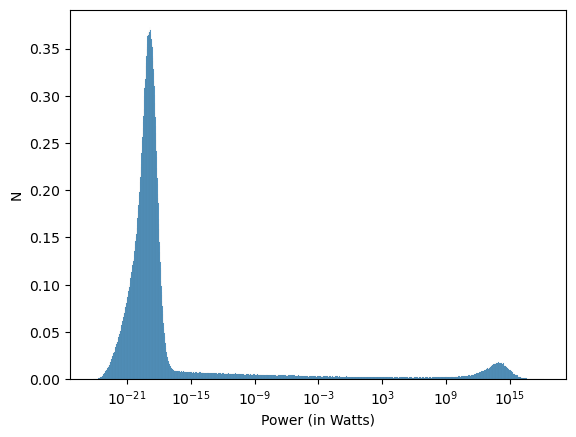

In [33]:
from MainFile import Surface_Element

# 16.543 (4 GHz), 24.814 (6 GHz), 33.085 (8 GHz)
stars4 = Surface_Element(B, P, alpha, pos, vel, distance, 16.543)

L_4 = stars4.interpolation() * 1.602176634e-19

#introducing DM NFW profile
L_4 = (L_4/rho_init) * rho_NFW(distance_from_GC)

sns.histplot(L_4, stat = "density", log_scale = 10)
plt.xlabel("Power (in Watts)")
plt.ylabel("N")
plt.show()

In [34]:
fobs4 = stars4.fobs()

delf_c_4, I_4, num4 = stars4.allsky_intensity(fobs4, L_4, bandwidth = 4/2.417 * 1e6)

kb = 1.380649e-23 * 1e26 # Jy m^2 K^-1
ma_4 = 4 # GHz
axion_wv_4 = (stars4.c * 1000) / (ma_4 * 1e9) # m
print(f"Wavelength corresponding to ma = 4 GHz: %.5f" % axion_wv_4, "m", sep = " ")
print(f"Frequency =  %.5f" % ma_4 + " GHz")
# System Temperature
T_4 = I_4 * (axion_wv_4**2) / (2 * kb)

Wavelength corresponding to ma = 4 GHz: 0.07495 m
Frequency =  4.00000 GHz


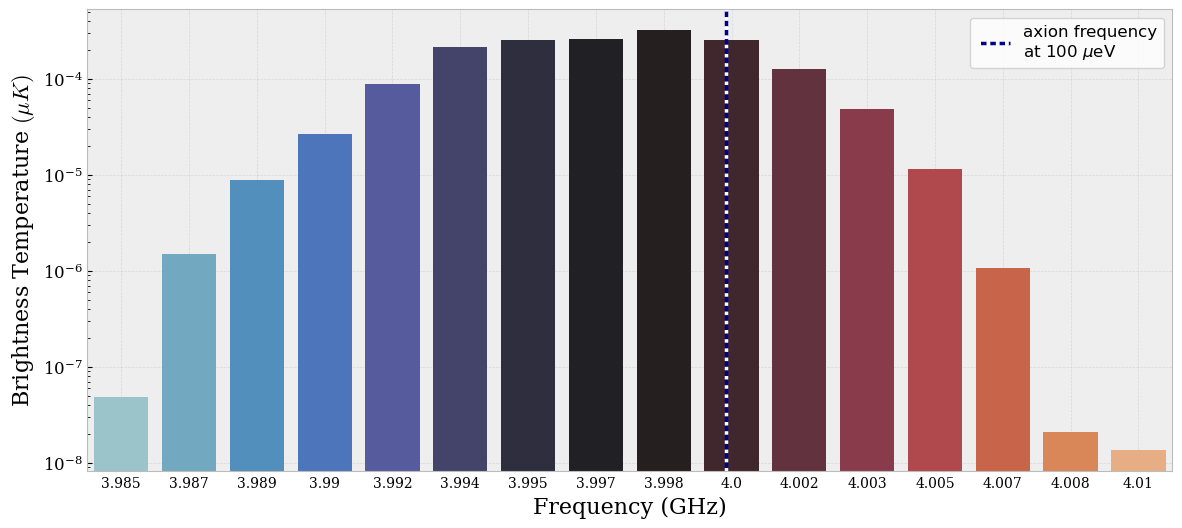

In [35]:
import seaborn as sns
from matplotlib import style

plt.figure(figsize = (14,6))


with plt.style.context('bmh'):
    plt.rcParams["font.family"] = "serif"
    plt.rcParams['axes.axisbelow'] = True
    sns.barplot(x = np.round(delf_c_4, decimals = 3), y = T_4 * 1e6, palette = "icefire")
    plt.axvline(x = (ma_4 - delf_c_4[0]) / ((delf_c_4[2] - delf_c_4[1])), 
                color = "white", label = r"axion frequency" + "\n" + r"at 100 $\mu$eV", alpha = 1,
                linestyle = ":", lw = 2.5, gapcolor = "darkblue")

    plt.yscale("log")
    plt.ylabel(r"Brightness Temperature $(\mu K)$", fontsize = 13+3)
    plt.xlabel("Frequency (GHz)", fontsize = 13+3)
    # plt.xticks(np.linspace(0, 155, 15, dtype = int), fontsize = 10)
    plt.yticks(fontsize = 11+1)
plt.legend(labelcolor = "black", facecolor = "white", fontsize = "large")
plt.grid(alpha = 0.4)
# plt.savefig("/Users/user/Desktop/Results/Report 5.0/All_sky_survey_Temp_plot.png", 
#             bbox_inches = "tight", dpi = 300)
plt.show()

[2.73671195e-09 3.99728722e+03 3.49948119e+00] in units of K, MHz, MHz.


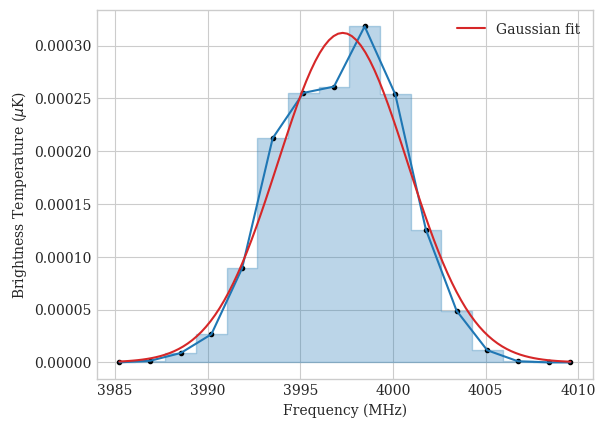

In [36]:
popt_4, pcov_4 = cf(gaussian, 1000 * delf_c_4, T_4, p0 = [1e-9, 1000 * ma_4, 1e2])

print(popt_4, "in units of K, MHz, MHz.", sep = " ")

gauss_fit_plot(1000 * delf_c_4, T_4, popt_4)

plt.show()

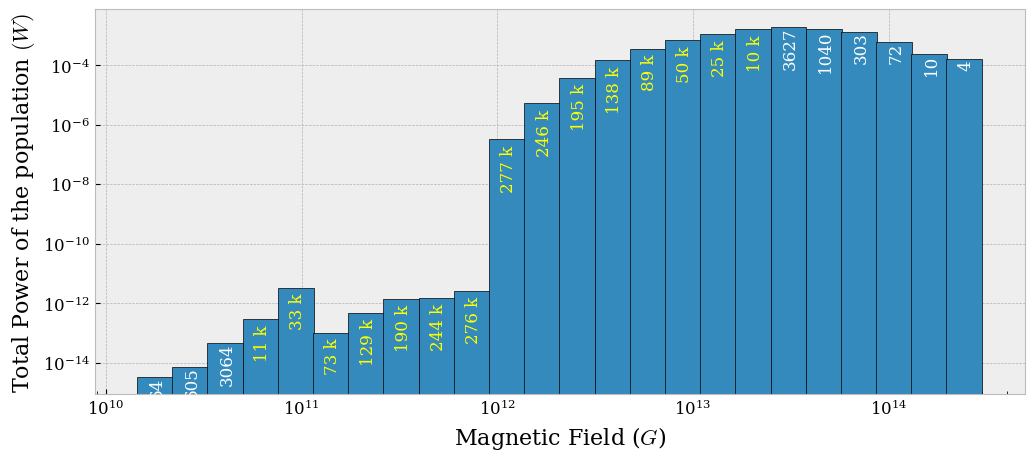

In [37]:
bins_4, bflux_4, count_4 = Bbins(L_4, 4/2.417 * 1e6)

Bplots(bins_4, bflux_4, count_4)
plt.show()

In [38]:
print("Number of Neutron stars contributing = ", (L_4[L_4 > 1e4]).size)

Number of Neutron stars contributing =  128228


<h2>$f_{m_a} = 6$ GHz</h2>

/var/folders/zn/fx9ngdfs335czg37p256r4_00000gp/T/ipykernel_25660/1810481906.py:4: SyntaxWarning: Order of parameters: B (in G), P (in seconds), alpha (in radiens), co-ordinates(x, y, z) (in kpc), velocity(vx, vy, vz) (in km/s), distance (in kpc), axion mass (in micro eV) and time (in Million years). Permissible axion mass values - 0.1, 1, 10, 16.543 (4 GHz), 24.814 (6 GHz), 33.085 (8 GHz), 100.
  stars6 = Surface_Element(B, P, alpha, pos, vel, distance, 24.814)


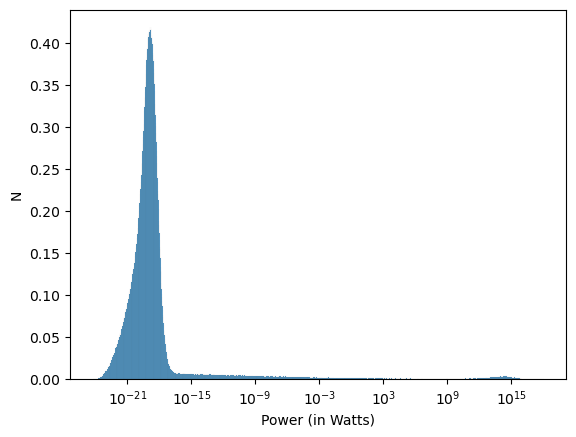

In [40]:
from MainFile import Surface_Element

# 16.543 (4 GHz), 24.814 (6 GHz), 33.085 (8 GHz)
stars6 = Surface_Element(B, P, alpha, pos, vel, distance, 24.814)

L_6 = stars6.interpolation() * 1.602176634e-19

#introducing DM NFW profile
L_6 = (L_6/rho_init) * rho_NFW(distance_from_GC)

sns.histplot(L_6, stat = "density", log_scale = 10)
plt.xlabel("Power (in Watts)")
plt.ylabel("N")
plt.show()

In [41]:
fobs6 = stars6.fobs()

delf_c_6, I_6, num6 = stars6.allsky_intensity(fobs6, L_6, bandwidth = 6/2.417 * 1e6)

kb = 1.380649e-23 * 1e26 # Jy m^2 K^-1
ma_6 = 6 # GHz
axion_wv_6 = (stars6.c * 1000) / (ma_6 * 1e9) # m
print(f"Wavelength corresponding to ma = 6 GHz: %.5f" % axion_wv_6, "m", sep = " ")
print(f"Frequency =  %.5f" % ma_6 + " GHz")
# System Temperature
T_6 = I_6 * (axion_wv_6**2) / (2 * kb)

Wavelength corresponding to ma = 6 GHz: 0.04997 m
Frequency =  6.00000 GHz


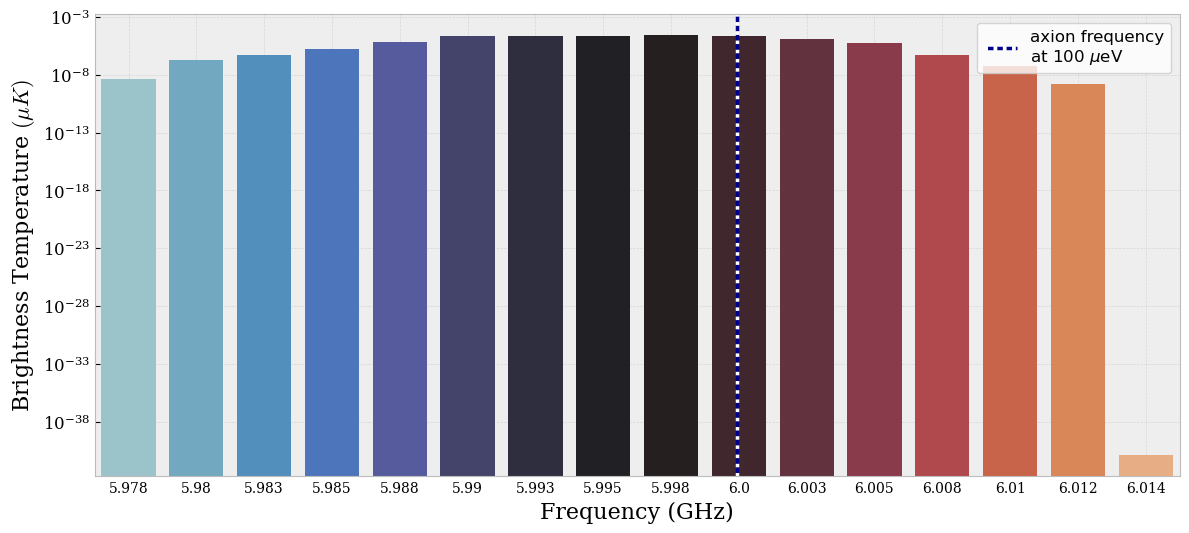

In [42]:
import seaborn as sns
from matplotlib import style

plt.figure(figsize = (14,6))

with plt.style.context('bmh'):
    plt.rcParams["font.family"] = "serif"
    plt.rcParams['axes.axisbelow'] = True
    sns.barplot(x = np.round(delf_c_6, decimals = 3), y = T_6 * 1e6, palette = "icefire")
    plt.axvline(x = (ma_6 - delf_c_6[0]) / ((delf_c_6[2] - delf_c_6[1])), 
                color = "white", label = r"axion frequency" + "\n" + r"at 100 $\mu$eV", alpha = 1,
                linestyle = ":", lw = 2.5, gapcolor = "darkblue")

    plt.yscale("log")
    plt.ylabel(r"Brightness Temperature $(\mu K)$", fontsize = 13+3)
    plt.xlabel("Frequency (GHz)", fontsize = 13+3)
    # plt.xticks(np.linspace(0, 155, 15, dtype = int), fontsize = 10)
    plt.yticks(fontsize = 11+1)
plt.legend(labelcolor = "black", facecolor = "white", fontsize = "large")
plt.grid(alpha = 0.4)
# plt.savefig("/Users/user/Desktop/Results/Report 5.0/All_sky_survey_Temp_plot.png", 
#             bbox_inches = "tight", dpi = 300)
plt.show()

[3.68628318e-10 5.99582571e+03 5.58720348e+00] in units of K, MHz, MHz.


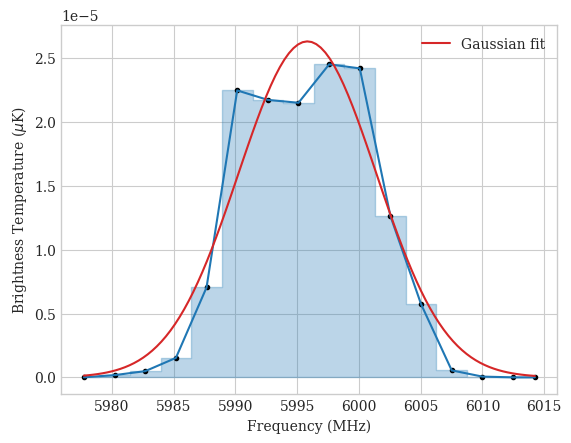

In [43]:
popt_6, pcov_6 = cf(gaussian, 1000 * delf_c_6, T_6, p0 = [1e-9, 1000 * ma_6, 1e2])

print(popt_6, "in units of K, MHz, MHz.", sep = " ")

gauss_fit_plot(1000 * delf_c_6, T_6, popt_6)

plt.show()

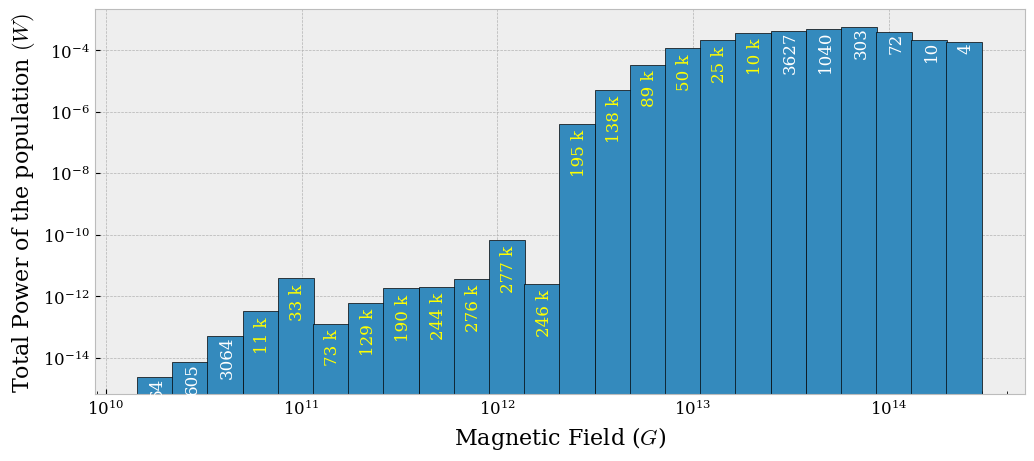

In [44]:
bins_6, bflux_6, count_6 = Bbins(L_6, 4/2.417 * 1e6)

Bplots(bins_6, bflux_6, count_6)
plt.show()

In [45]:
print("Number of Neutron stars contributing = ", (L_6[L_6 > 1e4]).size)

Number of Neutron stars contributing =  26483


<h2>$f_{m_a} = 8$ GHz</h2>

/var/folders/zn/fx9ngdfs335czg37p256r4_00000gp/T/ipykernel_25660/1939342412.py:4: SyntaxWarning: Order of parameters: B (in G), P (in seconds), alpha (in radiens), co-ordinates(x, y, z) (in kpc), velocity(vx, vy, vz) (in km/s), distance (in kpc), axion mass (in micro eV) and time (in Million years). Permissible axion mass values - 0.1, 1, 10, 16.543 (4 GHz), 24.814 (6 GHz), 33.085 (8 GHz), 100.
  stars8 = Surface_Element(B, P, alpha, pos, vel, distance, 33.085)


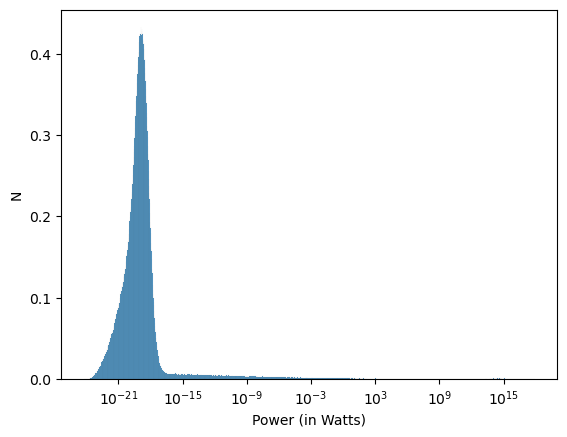

In [46]:
from MainFile import Surface_Element

# 16.543 (4 GHz), 24.814 (6 GHz), 33.085 (8 GHz)
stars8 = Surface_Element(B, P, alpha, pos, vel, distance, 33.085)

L_8 = stars8.interpolation() * 1.602176634e-19

#introducing DM NFW profile
L_8 = (L_8/rho_init) * rho_NFW(distance_from_GC)

sns.histplot(L_8, stat = "density", log_scale = 10)
plt.xlabel("Power (in Watts)")
plt.ylabel("N")
plt.show()

In [47]:
fobs8 = stars8.fobs()

delf_c_8, I_8, num8 = stars8.allsky_intensity(fobs8, L_8, bandwidth = 8/2.417 * 1e6)

kb = 1.380649e-23 * 1e26 # Jy m^2 K^-1
ma_8 = 8 # GHz
axion_wv_8 = (stars8.c * 1000) / (ma_8 * 1e9) # m
print(f"Wavelength corresponding to ma = 8 GHz: %.5f" % axion_wv_8, "m", sep = " ")
print(f"Frequency =  %.5f" % ma_8 + " GHz")
# System Temperature
T_8 = I_8 * (axion_wv_8**2) / (2 * kb)

Wavelength corresponding to ma = 8 GHz: 0.03747 m
Frequency =  8.00000 GHz


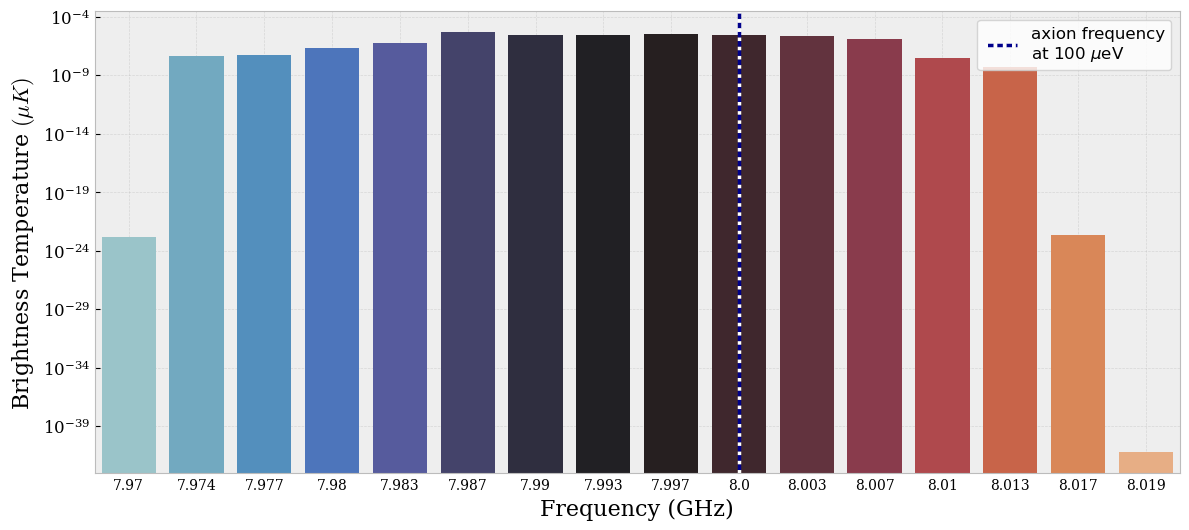

In [48]:
import seaborn as sns
from matplotlib import style

plt.figure(figsize = (14,6))


with plt.style.context('bmh'):
    plt.rcParams["font.family"] = "serif"
    plt.rcParams['axes.axisbelow'] = True
    sns.barplot(x = np.round(delf_c_8, decimals = 3), y = T_8 * 1e6, palette = "icefire")
    plt.axvline(x = (ma_8 - delf_c_8[0]) / ((delf_c_8[2] - delf_c_8[1])), 
                color = "white", label = r"axion frequency" + "\n" + r"at 100 $\mu$eV", alpha = 1,
                linestyle = ":", lw = 2.5, gapcolor = "darkblue")

    plt.yscale("log")
    plt.ylabel(r"Brightness Temperature $(\mu K)$", fontsize = 13+3)
    plt.xlabel("Frequency (GHz)", fontsize = 13+3)
    # plt.xticks(np.linspace(0, 155, 15, dtype = int), fontsize = 10)
    plt.yticks(fontsize = 11+1)
plt.legend(labelcolor = "black", facecolor = "white", fontsize = "large")
plt.grid(alpha = 0.4)
# plt.savefig("/Users/user/Desktop/Results/Report 5.0/All_sky_survey_Temp_plot.png", 
#             bbox_inches = "tight", dpi = 300)
plt.show()

[7.24488729e-11 7.99402730e+03 8.10503953e+00] in units of K, MHz, MHz.


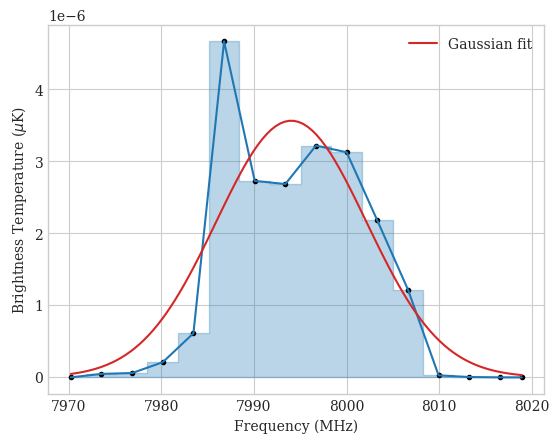

In [49]:
popt_8, pcov_8 = cf(gaussian, 1000 * delf_c_8, T_8, p0 = [1e-9, 1000 * ma_8, 1e2])

print(popt_8, "in units of K, MHz, MHz.", sep = " ")

gauss_fit_plot(1000 * delf_c_8, T_8, popt_8) 

plt.show()

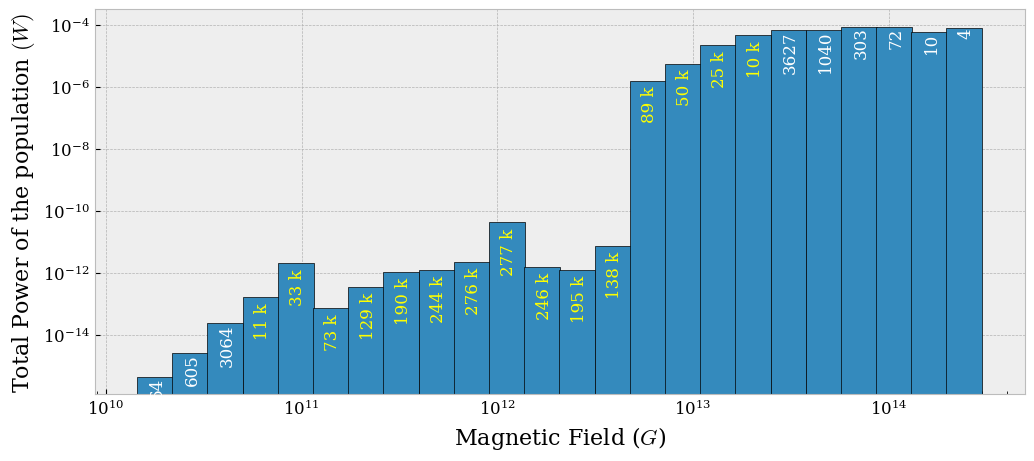

In [50]:
bins_8, bflux_8, count_8 = Bbins(L_8, 8/2.417 * 1e6)

Bplots(bins_8, bflux_8, count_8)
plt.show()

In [51]:
print("Number of Neutron stars contributing = ", (L_8[L_8 > 1e4]).size)

Number of Neutron stars contributing =  7930


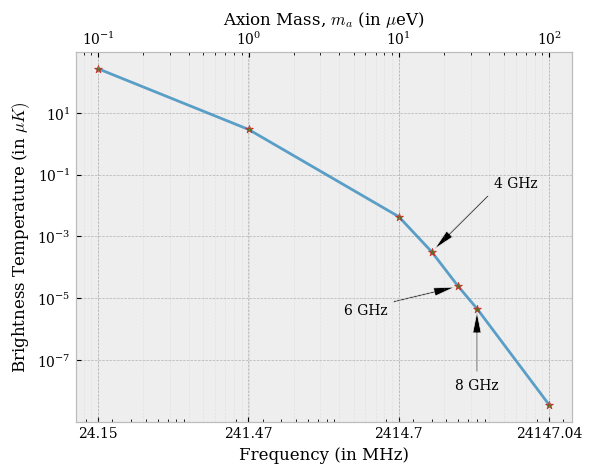

In [52]:
max_T = np.array([np.max(T_01), np.max(T_1), np.max(T_10), np.max(T_4),
                  np.max(T_6), np.max(T_8), np.max(T_100)])

freq = np.array([delf_c_01[T_01 == np.max(T_01)][0],
                        delf_c_1[T_1 == np.max(T_1)][0],
                        delf_c_10[T_10 == np.max(T_10)][0], 
                        4, 6, 8,
                        delf_c_100[T_100 == np.max(T_100)][0]])

axion_frequency = [0.1, 1, 10, 16.543, 24.814, 33.085, 100]

ax1_ticks = np.array([ma_01 / 1e3, ma_1 / 1e3, ma_10, ma_100])

# Set the style for the plot
with plt.style.context("bmh"):
    plt.rcParams["font.family"] = "serif"

    # Create a figure and add a subplot
    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    # Plot the data on the first y-axis (ax1)
    ax1.plot(freq, max_T * 1e6, alpha=0.8)
    ax1.set_xlabel("Frequency (in MHz)")
    ax1.set_ylabel(r"Brightness Temperature (in $\mu K)$")
    ax1.set_xscale("log")
    ax1.set_yscale("log")  # Set y-axis to log scale
    ax1.set_xticks(ax1_ticks, labels = np.array(np.round(1000 * ax1_ticks, 2), dtype = str))
    plt.annotate("4 GHz", (freq[3], 1e6 * max_T[3]), xytext=(freq[6] * 0.6, 1e8 * max_T[3]),
                 arrowprops=dict(width = 1, headlength = 15, headwidth = 6, facecolor='black', shrink=0.05, linewidth = 0.5), 
                 ha = "center", va = "bottom")

    plt.annotate("6 GHz", (freq[4], 1e6 * max_T[4]), xytext=(freq[2] * 0.6, 1e5 * max_T[4]),
                 arrowprops=dict(width = 1, headlength = 15, headwidth = 6, facecolor='black', shrink=0.05, linewidth = 0.5), 
                 ha = "center", va = "bottom")

    plt.annotate("8 GHz", (freq[5], 1e6 * max_T[5]), xytext=(freq[5], 0.2e4 * max_T[5]),
                 arrowprops=dict(width = 1, headlength = 15, headwidth = 6, facecolor='black', shrink=0.05, linewidth = 0.5), 
                 ha = "center", va = "bottom")

    # Create a second x-axis (ax2) on top of the existing plot
    ax2 = ax1.twiny()

    # Scatter plot on the second x-axis (ax2)
    ax2.scatter(axion_frequency, max_T * 1e6, alpha=1, marker="*", color="C3")
    ax2.set_xlabel(r"Axion Mass, $m_a$ (in $\mu$eV)")

    # Set the x-axis of ax2 to log scale
    ax2.set_xscale("log")
    
    # Set the grid for ax2
    ax2.grid(alpha=0.4, which="major")
    ax2.grid(alpha=0.2, which="minor")

# Display the plot
plt.show()


<Figure size 1400x700 with 0 Axes>

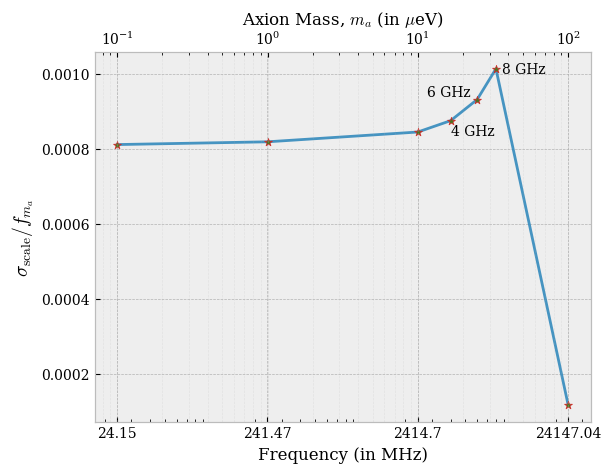

In [53]:
sigmas = np.array([popt_01[2], popt_1[2], popt_10[2], popt_4[2], popt_6[2], popt_8[2], popt_100[2]]) *1e-3


fig = plt.figure(figsize = (14,7))
with plt.style.context("bmh"):
    plt.rcParams["font.family"] = "serif"
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    
    ax1.plot(1000 * freq, sigmas / freq, alpha = 0.9)
    ax1.set_xlabel("Frequency (in MHz)")
    ax1.set_ylabel(r"$\sigma_{\rm scale} / f_{m_a}$", fontsize = 14)
    ax1.set_xscale("log")
    ax1.set_xticks(1000 * ax1_ticks, labels = np.array(np.round(1000 * ax1_ticks, 2), dtype=str) )
    
    ax2 = ax1.twiny()
    ax2.scatter(axion_frequency, sigmas/freq, alpha=1, marker="*", color="C3")
    ax2.set_xlabel(r"Axion Mass, $m_a$ (in $\mu$eV)")
    ax2.ticklabel_format(axis='x', style='plain', useOffset=False)
    
    ax2.set_xscale("log")  # Set x-axis of ax2 to log scale
    ax2.grid(alpha=0.4 , which = "major")
    ax2.grid(alpha = 0.2, which = "minor")

    ax1.text(1000 * freq[3], 0.99 * sigmas[3] / freq[3], "4 GHz", ha = "left", va = "top", fontfamily = "serif")
    ax1.text(1000 * 0.9 * freq[4],  sigmas[4] / freq[4], "6 GHz", ha = "right", va = "bottom", fontfamily = "serif")
    ax1.text(1000 * freq[5] * 1.1,  sigmas[5] / freq[5], "8 GHz", ha = "left", va = "center", fontfamily = "serif")

plt.show()